In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import sys
sys.path.append("./../")

In [133]:
from pathlib import Path
import math
import pickle
#
import torch
import torchvision
from torchvision import utils
import torchvision.transforms as T
import torchvision.datasets as datasets
#
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#
from misc.plot_utils import plot_mat, imshow
from effcn.functions import max_norm_masking
from effcn.models import MnistEcnBackbone, MnistEcnDecoder, MnistEffCapsNet

### Preprocessing

In [134]:
device = torch.device("cuda")
device

device(type='cuda')

In [135]:
p_experiment = "/mnt/data/experiments/EfficientCN/mnist"
p_experiment = Path(p_experiment)

p_ckpts = p_experiment / "run_2022-01-19_14-50-25"


p_data = Path("/mnt/data/datasets")
p_model = p_ckpts / "ecn_mnist_epoch_150.ckpt"
p_model.exists()

True

In [136]:
model = MnistEffCapsNet()
model.load_state_dict(torch.load(p_model))
model = model.to(device)
model.eval()

MnistEffCapsNet(
  (backbone): MnistEcnBackbone(
    (layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (7): ReLU(inplace=True)
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
      (10): ReLU(inplace=True)
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (primcaps): PrimaryCaps(
    (dw_conv2d): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=valid, groups=128)
 

In [137]:
ds_train = datasets.MNIST(root=p_data, train=True, download=True)#, transform=T.ToTensor(), target_transform=T.ToTensor())
ds_valid = datasets.MNIST(root=p_data, train=False, download=True)#, transform=None, target_transform=T.ToTensor())
  

In [138]:
idx = 0

print(len(ds_train.data))

x = ds_train.data[idx]
y = ds_train.targets[idx]



x = torch.unsqueeze(torch.unsqueeze(x,dim=0),dim=0).float()
y = torch.unsqueeze(y,dim=0)

print(x.size())
print(y.size(), y)

60000
torch.Size([1, 1, 28, 28])
torch.Size([1]) tensor([5])


### Generate Capsuls for influenced Reconstruction

In [139]:
x = x.to(device)
uh, _ = model.forward(x)

In [140]:
print(uh.size())

torch.Size([1, 10, 16])


In [141]:
m_uh = max_norm_masking(uh)
m_uh = torch.flatten(m_uh, start_dim=1)
x_rec = model.decoder(m_uh)

In [142]:
def imshow(img, cmap="gray", vmin=None, vmax=None):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap, vmin=None, vmax=None)
    plt.show()

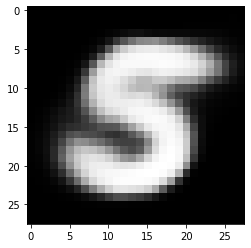

In [143]:
imshow(torch.squeeze(x_rec,dim=0))

tensor([[ 2,  2, 10,  0,  7, 15,  1,  0,  7,  6]], device='cuda:0')


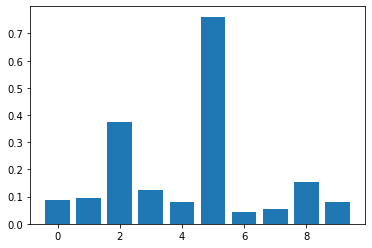

tensor([ 0.1782, -0.2600, -0.2329, -0.1805,  0.0047,  0.1343,  0.2104, -0.2027,
         0.1962,  0.0159, -0.1678, -0.1830, -0.2096, -0.1591, -0.2202,  0.2692],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.2782, -0.2600, -0.3329, -0.1805,  0.0047,  0.1343,  0.3104, -0.2027,
         0.1962,  0.0159, -0.1678, -0.1830, -0.2096, -0.1591, -0.2202,  0.2692],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.2164, -0.2185, -0.2446, -0.1346, -0.0062,  0.1444,  0.1861, -0.1734,
         0.2403, -0.0208, -0.1243, -0.1736, -0.1726, -0.1524, -0.1961,  0.2621],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


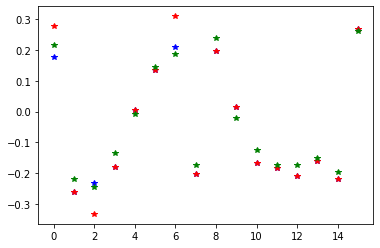

torch.Size([3, 10, 16])

In [144]:
print(torch.argmax(uh,dim=2))

sq_uh = torch.squeeze(uh,dim=0)
a = torch.norm(sq_uh, dim=1)
plt.bar(np.arange(0,10,1), a.detach().cpu().numpy())
plt.show()

i_cap = torch.argmax(torch.norm(uh, dim=2))
ref = uh[:,i_cap,:]

uh_delta = uh.clone()
uh_delta[:,i_cap,:] += torch.tensor([0.1,0,-0.1,0,0,0,0.1,0,0,0,0,0,0,0,0,0]).to(device)
delta = uh_delta[:,i_cap,:]

torch.manual_seed(42)
uh_delta2 = uh.clone()
uh_delta2[:,i_cap,:] += (torch.rand(16).to(device)-0.5) * 0.1
delta2 = uh_delta2[:,i_cap,:]

print(torch.squeeze(ref,dim=0))
plt.plot(torch.squeeze(ref,dim=0).detach().cpu().numpy(),"b*")
print(torch.squeeze(delta,dim=0))
plt.plot(torch.squeeze(delta,dim=0).detach().cpu().numpy(),"r*")
print(torch.squeeze(delta2,dim=0))
plt.plot(torch.squeeze(delta2,dim=0).detach().cpu().numpy(),"g*")
plt.show()




uh_n = torch.cat((uh, uh_delta, uh_delta2), dim=0)  

uh_n.size()

#print(uh_delta-uh)


In [145]:
m_uh_n = max_norm_masking(uh_n)
m_uh_n = torch.flatten(m_uh_n, start_dim=1)
x_rec_n = model.decoder(m_uh_n)

torch.Size([3, 1, 28, 28])


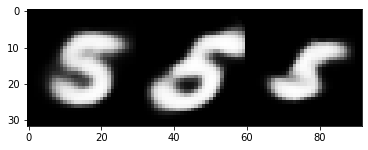

In [146]:
print(x_rec_n.size())
rec = x_rec_n.cpu()
scal = lambda x: (x-x.min())/(x.max()-x.min())
img = torchvision.utils.make_grid(torch.cat([scal(rec)], dim=0), nrow=rec.shape[0])
plt.imshow(img.permute(1,2,0))
plt.show()

### Prepare affine transformations embedding

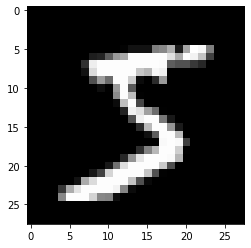

In [147]:
x_aff = T.functional.affine(img=x, angle=0, translate=[0,0], scale=1.,shear=0)

imshow(torch.squeeze(x_aff,dim=0))

In [148]:
def affine_xtrans(img, target, range=[-5.,5.,1]):
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    x_trans = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        x_trans[i] = T.functional.affine(img=x, angle=0, translate=[l,0], scale=1.,shear=0)
        l_target[i] = target
    
    return x_trans, l_target

def affine_ytrans(img, target, range=[-5.,5.,1]):
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    y_trans = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        y_trans[i] = T.functional.affine(img=x, angle=0, translate=[0,l], scale=1.,shear=0)
        l_target[i] = target
    
    return y_trans, l_target

def affine_rot(img, target, range=[-25.,25.,1]):
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    rot = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        rot[i] = T.functional.affine(img=x, angle=l, translate=[0,0], scale=1.,shear=0)
        l_target[i] = target
    
    return rot, l_target

torch.Size([11, 1, 28, 28])
tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])


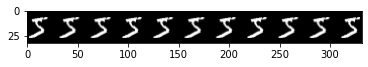

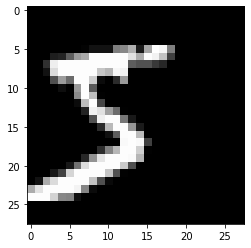

In [160]:
x_trams, y_trans = affine_xtrans(x,y)
print(x_trams.shape)
print(y_trans)

x_trams = x_trams.cpu()
scal = lambda x: (x-x.min())/(x.max()-x.min())
img = torchvision.utils.make_grid(torch.cat([scal(x_trams)], dim=0), nrow=x_trams.shape[0])
plt.imshow(img.permute(1,2,0))
plt.show()

imshow(x_trams[0,:,:,:])


In [161]:
x_trans, _ = affine_xtrans(x,y)
y_trans, _ = affine_ytrans(x,y)
rot, _ = affine_rot(x,y)

### ATE on x_trans

In [180]:
#x_aff = x_trans.to(device)
#x_aff = y_trans.to(device)
x_aff = rot.to(device)

uh_aff, _ = model.forward(x_aff)

In [181]:
def cov_uh_trans(uh):
    """
    uh in [k,n,m]
    k -> number of transformed images
    n -> number of output classes
    m -> number of capsul values
    """

    uh_mean = uh.mean(dim=0)
    """
    #could be cleaner, but it's the same ...
    uh_mean = uh_mean.unsqueeze(0)
    uh_mean = uh_mean.repeat(uh.shape[0],1,1)
    """

    z = uh - uh_mean

    c_k = torch.einsum('...ij, ...ik -> ...jk', z,z)
    c = torch.einsum('ijk -> jk', c_k) / c_k.shape[0]

    return c

In [182]:
c = cov_uh_trans(uh_aff)


In [183]:
def covshow(c):
    # https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

    data = c.cpu().detach().numpy()

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(data)

    fg_color = 'white'
    im.axes.tick_params(color=fg_color, labelcolor=fg_color)

    """
    # Loop over data dimensions and create text annotations.
    for i in range(len(data)):
        for j in range(len(data)):
            text = ax.text(j, i, data[i, j],
                        ha="center", va="center", color="fg_color")
    """

    cb = fig.colorbar(im)
    cb.ax.yaxis.set_tick_params(color=fg_color)
    cb.outline.set_edgecolor(fg_color)
    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)
    fig.tight_layout()
    plt.show()

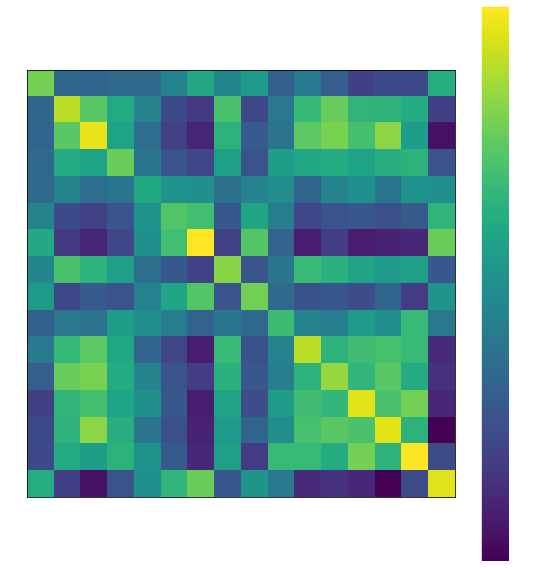

In [184]:
covshow(c)

### via PCA from Paper EffCN

tensor([0.5077, 0.1296, 0.0924, 0.0647, 0.0462, 0.0337, 0.0229, 0.0222, 0.0167,
        0.0158, 0.0128, 0.0043, 0.0097, 0.0060, 0.0073, 0.0081],
       grad_fn=<DivBackward0>)


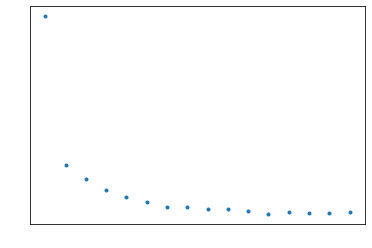

In [185]:
cov = c.cpu()

eig, v_eig = torch.linalg.eig(cov)
eig = eig.float()
sig = eig / eig.sum()

#rint(eig)
#print(eig.sum())
print(sig)
plt.plot(sig.detach().numpy(),".")
plt.tick_params(colors="w")



### Via KL-Divergende from munich paper

In [186]:
### !!! Not shure about this!!!

# https://mail.python.org/pipermail/scipy-user/2011-May/029521.html

def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
continuous distributions IEEE International Symposium on Information
Theory, 2008.
  """
  from scipy.spatial import cKDTree as KDTree

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [187]:
def cov_uh_kl(uh):
    c_k = torch.einsum('...ij, ...ik -> ...jk', uh,uh)
    c = torch.einsum('ijk -> jk', c_k) / c_k.shape[0]
    return c 

3.533581875136041


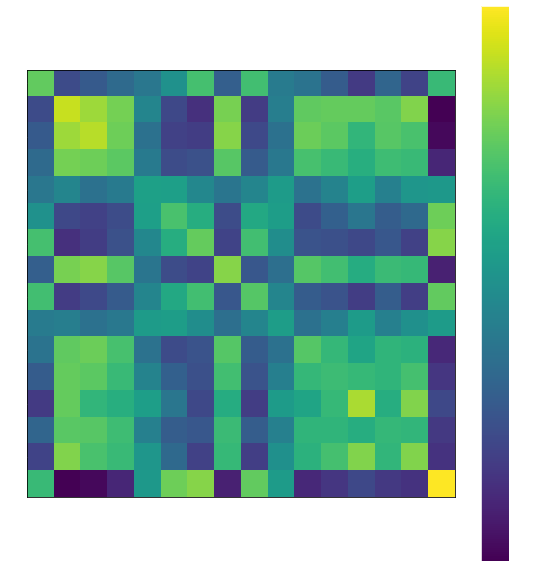

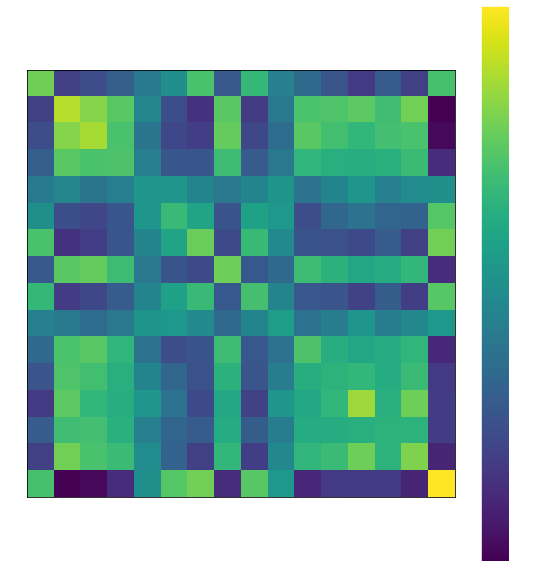

In [188]:
c_org = cov_uh_kl(uh.cpu())
c_aff = cov_uh_kl(uh_aff.cpu())

#determinaten
c_org_det = torch.linalg.det(c_org)
c_aff_det = torch.linalg.det(c_aff)

#trace
c_org_det = torch.trace(c_org)
c_aff_det = torch.trace(c_aff)

#compute kl div from git hub
kl_div = KLdivergence(c_org.detach().numpy(), c_aff.detach().numpy())

print(kl_div)
covshow(c_org)
covshow(c_aff)